In [1]:
# Collection Timeline and Spending Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
sys.path.append('../src')

from dotenv import load_dotenv
load_dotenv('../.env')

from google.cloud import bigquery
from config.bigquery_config import config

client = config.get_client()

# Collection value over time
timeline_query = """
SELECT 
    pc.purchase_date,
    pc.purchase_price,
    dr.title,
    dr.artist,
    pc.condition,
    pc.personal_rating,
    SUM(pc.purchase_price) OVER (ORDER BY pc.purchase_date) as cumulative_value
FROM `vinyl_catalog.personal_collection` pc
JOIN `vinyl_catalog.discogs_releases` dr ON pc.release_id = dr.release_id
ORDER BY pc.purchase_date
"""

timeline_data = client.query(timeline_query).to_dataframe()
print("Collection Timeline:")
print(timeline_data.to_string(index=False))

Collection Timeline:
purchase_date  purchase_price          title              artist condition  personal_rating  cumulative_value
   2020-02-27              28   Kind of Blue         Miles Davis       VG+                9                28
   2020-05-17              45 A Love Supreme       John Coltrane      Mint               10                73
   2020-09-28              35    Giant Steps       John Coltrane        VG                9               108
   2021-02-05              32     Blue Train       John Coltrane Near Mint                8               140
   2021-06-15              25 Somethin' Else Cannonball Adderley     Good+                8               165


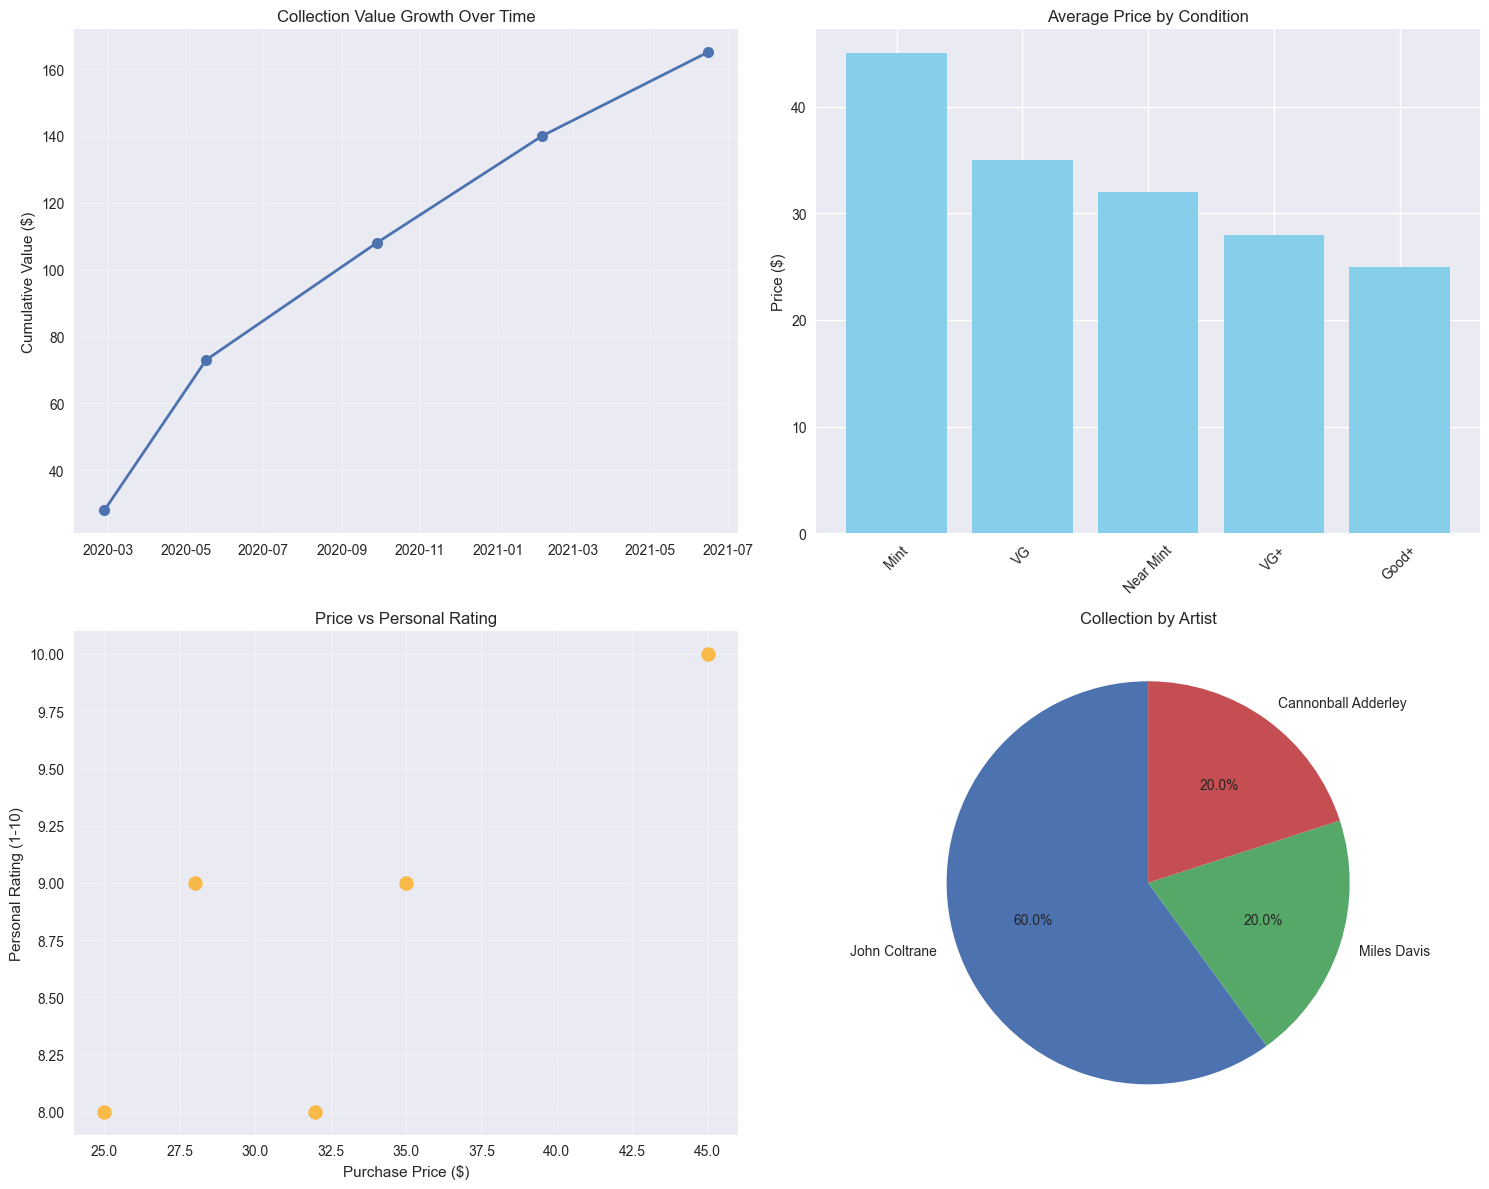

Total collection value: $165
Average price per album: $33.00
Price range: $25 - $45


In [2]:
# Create collection visualizations
plt.style.use('seaborn-v0_8')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Collection value over time
timeline_data['purchase_date'] = pd.to_datetime(timeline_data['purchase_date'])
ax1.plot(timeline_data['purchase_date'], timeline_data['cumulative_value'], 
         marker='o', linewidth=2, markersize=8)
ax1.set_title('Collection Value Growth Over Time')
ax1.set_ylabel('Cumulative Value ($)')
ax1.grid(True, alpha=0.3)

# 2. Price by condition
condition_data = timeline_data.groupby('condition')['purchase_price'].mean().sort_values(ascending=False)
ax2.bar(condition_data.index, condition_data.values, color='skyblue')
ax2.set_title('Average Price by Condition')
ax2.set_ylabel('Price ($)')
ax2.tick_params(axis='x', rotation=45)

# 3. Personal rating vs purchase price
ax3.scatter(timeline_data['purchase_price'], timeline_data['personal_rating'], 
           s=100, alpha=0.7, color='orange')
ax3.set_xlabel('Purchase Price ($)')
ax3.set_ylabel('Personal Rating (1-10)')
ax3.set_title('Price vs Personal Rating')
ax3.grid(True, alpha=0.3)

# 4. Artist frequency
artist_counts = timeline_data['artist'].value_counts()
ax4.pie(artist_counts.values, labels=artist_counts.index, autopct='%1.1f%%', startangle=90)
ax4.set_title('Collection by Artist')

plt.tight_layout()
plt.show()

print(f"Total collection value: ${timeline_data['cumulative_value'].iloc[-1]}")
print(f"Average price per album: ${timeline_data['purchase_price'].mean():.2f}")
print(f"Price range: ${timeline_data['purchase_price'].min()} - ${timeline_data['purchase_price'].max()}")

In [3]:
# Advanced collection analysis queries
print("ADVANCED COLLECTION ANALYSIS")
print("=" * 50)

# 1. Label analysis
label_analysis_query = """
SELECT 
    dr.label,
    COUNT(*) as albums,
    AVG(pc.purchase_price) as avg_price,
    AVG(pc.personal_rating) as avg_personal_rating,
    AVG(ar.rating) as avg_critic_rating
FROM `vinyl_catalog.personal_collection` pc
JOIN `vinyl_catalog.discogs_releases` dr ON pc.release_id = dr.release_id
JOIN `vinyl_catalog.album_reviews` ar ON pc.release_id = ar.album_id
GROUP BY dr.label
ORDER BY albums DESC, avg_personal_rating DESC
"""

label_data = client.query(label_analysis_query).to_dataframe()
print("LABEL ANALYSIS:")
print(label_data.to_string(index=False))

# 2. Era analysis
era_analysis_query = """
SELECT 
    CASE 
        WHEN dr.year BETWEEN 1950 AND 1959 THEN '1950s'
        WHEN dr.year BETWEEN 1960 AND 1969 THEN '1960s'
        WHEN dr.year BETWEEN 1970 AND 1979 THEN '1970s'
        ELSE 'Other'
    END as era,
    COUNT(*) as albums,
    AVG(pc.purchase_price) as avg_price,
    AVG(pc.personal_rating) as avg_rating,
    STRING_AGG(dr.title, ', ') as albums_list
FROM `vinyl_catalog.personal_collection` pc
JOIN `vinyl_catalog.discogs_releases` dr ON pc.release_id = dr.release_id
GROUP BY era
ORDER BY era
"""

era_data = client.query(era_analysis_query).to_dataframe()
print("\nERA ANALYSIS:")
print(era_data.to_string(index=False))

# 3. Value-to-rating analysis
value_rating_query = """
SELECT 
    dr.title,
    dr.artist,
    pc.purchase_price,
    pc.personal_rating,
    ar.rating as critic_rating,
    ROUND(pc.personal_rating / pc.purchase_price, 2) as value_per_dollar
FROM `vinyl_catalog.personal_collection` pc
JOIN `vinyl_catalog.discogs_releases` dr ON pc.release_id = dr.release_id
JOIN `vinyl_catalog.album_reviews` ar ON pc.release_id = ar.album_id
ORDER BY value_per_dollar DESC
"""

value_data = client.query(value_rating_query).to_dataframe()
print("\nVALUE ANALYSIS (Personal Rating per Dollar):")
print(value_data.to_string(index=False))

ADVANCED COLLECTION ANALYSIS
LABEL ANALYSIS:
    label  albums  avg_price  avg_personal_rating  avg_critic_rating
Blue Note       2       28.5                  8.0               4.35
 Impulse!       1       45.0                 10.0               4.90
 Columbia       1       28.0                  9.0               4.80
 Atlantic       1       35.0                  9.0               4.60

ERA ANALYSIS:
  era  albums  avg_price  avg_rating                              albums_list
1950s       3  28.333333    8.333333 Blue Train, Somethin' Else, Kind of Blue
1960s       2  40.000000    9.500000              Giant Steps, A Love Supreme

VALUE ANALYSIS (Personal Rating per Dollar):
         title              artist  purchase_price  personal_rating  critic_rating  value_per_dollar
  Kind of Blue         Miles Davis              28                9            4.8              0.32
Somethin' Else Cannonball Adderley              25                8            4.3              0.32
   Giant Ste

In [4]:
# Export collection data for external analysis
export_query = """
SELECT 
    dr.title,
    dr.artist,
    dr.year,
    dr.genre,
    dr.style,
    dr.label,
    dr.country,
    pc.purchase_date,
    pc.purchase_price,
    pc.condition,
    pc.personal_rating,
    pc.times_played,
    ar.rating as critic_rating,
    ar.review_source,
    SUBSTR(ar.review_text, 1, 200) as review_excerpt
FROM `vinyl_catalog.personal_collection` pc
JOIN `vinyl_catalog.discogs_releases` dr ON pc.release_id = dr.release_id
JOIN `vinyl_catalog.album_reviews` ar ON pc.release_id = ar.album_id
ORDER BY pc.personal_rating DESC, pc.purchase_price DESC
"""

export_data = client.query(export_query).to_dataframe()

# Save to CSV for backup/sharing
export_data.to_csv('../data/processed/vinyl_collection_export.csv', index=False)
print("Collection exported to CSV")

# Generate collection report
print("VINYL COLLECTION REPORT")
print("=" * 50)
print(f"Collection Size: {len(export_data)} albums")
print(f"Total Investment: ${export_data['purchase_price'].sum()}")
print(f"Average Album Price: ${export_data['purchase_price'].mean():.2f}")
print(f"Price Range: ${export_data['purchase_price'].min()} - ${export_data['purchase_price'].max()}")
print(f"Collection Span: {export_data['year'].min()} - {export_data['year'].max()}")
print(f"Average Personal Rating: {export_data['personal_rating'].mean():.1f}/10")
print(f"Average Critic Rating: {export_data['critic_rating'].mean():.1f}/5")
print(f"Most Expensive Album: {export_data.loc[export_data['purchase_price'].idxmax(), 'title']}")
print(f"Highest Rated Album: {export_data.loc[export_data['personal_rating'].idxmax(), 'title']}")

# Label distribution
print(f"\nLabel Distribution:")
label_dist = export_data['label'].value_counts()
for label, count in label_dist.items():
    print(f"  {label}: {count} albums")

Collection exported to CSV
VINYL COLLECTION REPORT
Collection Size: 5 albums
Total Investment: $165
Average Album Price: $33.00
Price Range: $25 - $45
Collection Span: 1957 - 1965
Average Personal Rating: 8.8/10
Average Critic Rating: 4.6/5
Most Expensive Album: A Love Supreme
Highest Rated Album: A Love Supreme

Label Distribution:
  Blue Note: 2 albums
  Impulse!: 1 albums
  Atlantic: 1 albums
  Columbia: 1 albums


In [5]:
# Market trend analysis and collection gaps
print("MARKET ANALYSIS & COLLECTION INSIGHTS")
print("=" * 50)

# Label market analysis
label_market_query = """
SELECT 
    dr.label,
    COUNT(*) as albums_owned,
    AVG(pc.purchase_price) as avg_price_paid,
    AVG(pc.personal_rating) as avg_personal_rating,
    AVG(ar.rating) as avg_critic_rating,
    STRING_AGG(dr.title, ', ' ORDER BY pc.personal_rating DESC) as top_albums
FROM `vinyl_catalog.personal_collection` pc
JOIN `vinyl_catalog.discogs_releases` dr ON pc.release_id = dr.release_id
JOIN `vinyl_catalog.album_reviews` ar ON pc.release_id = ar.album_id
GROUP BY dr.label
ORDER BY albums_owned DESC, avg_personal_rating DESC
"""

label_analysis = client.query(label_market_query).to_dataframe()
print("LABEL ANALYSIS:")
for _, row in label_analysis.iterrows():
    print(f"\n{row['label']}:")
    print(f"  Albums: {row['albums_owned']}")
    print(f"  Avg Price: ${row['avg_price_paid']:.2f}")
    print(f"  Personal Rating: {row['avg_personal_rating']:.1f}/10")
    print(f"  Critic Rating: {row['avg_critic_rating']:.1f}/5")

# Investment efficiency analysis
investment_query = """
SELECT 
    dr.title,
    dr.artist,
    pc.purchase_price,
    pc.personal_rating,
    pc.times_played,
    ROUND(pc.personal_rating / pc.purchase_price, 2) as rating_per_dollar,
    ROUND(pc.times_played / pc.purchase_price, 1) as plays_per_dollar
FROM `vinyl_catalog.personal_collection` pc
JOIN `vinyl_catalog.discogs_releases` dr ON pc.release_id = dr.release_id
ORDER BY rating_per_dollar DESC
"""

investment_data = client.query(investment_query).to_dataframe()
print(f"\nINVESTMENT EFFICIENCY (Rating per Dollar Spent):")
print(investment_data.to_string(index=False))

best_value = investment_data.iloc[0]
print(f"\nBest Value Purchase: {best_value['title']} by {best_value['artist']}")
print(f"  Price: ${best_value['purchase_price']}, Rating: {best_value['personal_rating']}/10")
print(f"  Value Score: {best_value['rating_per_dollar']} rating points per dollar")

MARKET ANALYSIS & COLLECTION INSIGHTS
LABEL ANALYSIS:

Blue Note:
  Albums: 2
  Avg Price: $28.50
  Personal Rating: 8.0/10
  Critic Rating: 4.3/5

Impulse!:
  Albums: 1
  Avg Price: $45.00
  Personal Rating: 10.0/10
  Critic Rating: 4.9/5

Columbia:
  Albums: 1
  Avg Price: $28.00
  Personal Rating: 9.0/10
  Critic Rating: 4.8/5

Atlantic:
  Albums: 1
  Avg Price: $35.00
  Personal Rating: 9.0/10
  Critic Rating: 4.6/5

INVESTMENT EFFICIENCY (Rating per Dollar Spent):
         title              artist  purchase_price  personal_rating  times_played  rating_per_dollar  plays_per_dollar
Somethin' Else Cannonball Adderley              25                8            44               0.32               1.8
  Kind of Blue         Miles Davis              28                9            42               0.32               1.5
   Giant Steps       John Coltrane              35                9            29               0.26               0.8
    Blue Train       John Coltrane              32